In [44]:
# Milestone 5: Advanced Model Development - Part 1
# Import libraries and set up environment

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import joblib


In [45]:
# Part 2: Load and prepare data (robust target detection with fallback)

# Example: Replace this with your cleaned dataset file path
import pandas as pd
from sklearn.model_selection import train_test_split

data = pd.read_csv("cleaned_dynamic_pricing.csv")
# Normalize column names to be robust to variants
data.columns = data.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('-', '_')

# Candidate target names (priority order)
target_candidates = [
    'optimal_price', 'optimalprice', 'optimal_price_usd',
    'optimal_price_inr', 'price', 'fare', 'predicted_price', 'pred_price', 'dynamic_price'
]

# Allow the user to override mapping by setting a dict named `COLUMN_MAP` earlier in notebook
# e.g. COLUMN_MAP = {'target': 'optimal_price'}
mapped_target = None
# Use globals().get to avoid NameError if COLUMN_MAP is not defined
user_column_map = globals().get('COLUMN_MAP', None)
if isinstance(user_column_map, dict):
    # attempt to use mapping if provided (normalize mapping key and value to match normalized data.columns)
    user_target = user_column_map.get('target')
    if user_target:
        user_target = str(user_target).strip().lower().replace(' ', '_').replace('-', '_')
        if user_target in data.columns:
            mapped_target = user_target
        else:
            print(f"Warning: COLUMN_MAP['target']='{user_target}' not found in data columns.")

# Find the first matching candidate in the dataframe
target_col = mapped_target
if target_col is None:
    for c in target_candidates:
        if c in data.columns:
            target_col = c
            break

# Fallback: if no explicit target found, try a sensible default if available
if target_col is None:
    if 'historical_cost_of_ride' in data.columns:
        target_col = 'historical_cost_of_ride'
        print("No explicit target (e.g. Optimal_Price) found — falling back to 'historical_cost_of_ride' as the target.")
    else:
        # helpful error listing available columns
        raise KeyError(
            f"No target column found. Available columns: {list(data.columns)}\n"
            f"Please set COLUMN_MAP = {{'target': '<your_column_name>'}} or rename your column to one of: {target_candidates}"
        )

# Prepare target and features
y = pd.to_numeric(data[target_col], errors='coerce')
X = data.drop(columns=[target_col])

# Quick NaN check for the target
nan_frac = y.isna().mean()
if nan_frac > 0.1:
    print(f"Warning: {nan_frac:.2%} of target values are NaN after coercion. Check your '{target_col}' column.")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Data split complete.")
print(f"Training size: {X_train.shape}, Test size: {X_test.shape}")


No explicit target (e.g. Optimal_Price) found — falling back to 'historical_cost_of_ride' as the target.
Data split complete.
Training size: (800, 9), Test size: (200, 9)


In [46]:
# Part 3: Train XGBoost Model

xgb_model = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Preprocess categorical features for XGBoost: one-hot encode object/category columns
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
if len(cat_cols) > 0:
    X_train_enc = pd.get_dummies(X_train, columns=cat_cols, drop_first=False)
    X_test_enc = pd.get_dummies(X_test, columns=cat_cols, drop_first=False)
    # Ensure train and test have the same columns
    X_test_enc = X_test_enc.reindex(columns=X_train_enc.columns, fill_value=0)
else:
    X_train_enc = X_train.copy()
    X_test_enc = X_test.copy()

xgb_model.fit(X_train_enc, y_train)
y_pred_xgb = xgb_model.predict(X_test_enc)

print("XGBoost Model Performance:")
print("MAE:", mean_absolute_error(y_test, y_pred_xgb))
print("R2 Score:", r2_score(y_test, y_pred_xgb))




XGBoost Model Performance:
MAE: 57.298280450862165
R2 Score: 0.8411244266996174


In [47]:
# Part 4: Train LightGBM Model

lgb_model = lgb.LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Use the one-hot encoded dataframes (created earlier for XGBoost) so LightGBM receives numeric/bool dtypes.
# If those encoded frames are not present for any reason, fall back to creating them here.
try:
    X_fit = X_train_enc
    X_pred = X_test_enc
except NameError:
    cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
    if len(cat_cols) > 0:
        X_fit = pd.get_dummies(X_train, columns=cat_cols, drop_first=False)
        X_pred = pd.get_dummies(X_test, columns=cat_cols, drop_first=False)
        # Ensure same columns between train and test
        X_pred = X_pred.reindex(columns=X_fit.columns, fill_value=0)
    else:
        X_fit = X_train.copy()
        X_pred = X_test.copy()

lgb_model.fit(X_fit, y_train)
y_pred_lgb = lgb_model.predict(X_pred)

print("LightGBM Model Performance:")
print("MAE:", mean_absolute_error(y_test, y_pred_lgb))
print("R2 Score:", r2_score(y_test, y_pred_lgb))




LightGBM Model Performance:
MAE: 58.296150271590385
R2 Score: 0.8292252036737627
LightGBM Model Performance:
MAE: 58.296150271590385
R2 Score: 0.8292252036737627


In [48]:
# Evaluate the models by MSE, MAE, R2
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

mse_lgb = mean_squared_error(y_test, y_pred_lgb)
mae_lgb = mean_absolute_error(y_test, y_pred_lgb)
r2_lgb = r2_score(y_test, y_pred_lgb)

print("\nXGBoost Model Performance:")
print(f"Mean Squared Error (MSE): {mse_xgb}")
print(f"Mean Absolute Error (MAE): {mae_xgb}")
print(f"R-squared (R2): {r2_xgb}")

print("\nLightGBM Model Performance:")
print(f"Mean Squared Error (MSE): {mse_lgb}")
print(f"Mean Absolute Error (MAE): {mae_lgb}")
print(f"R-squared (R2): {r2_lgb}")

# Compare actual and predicted values
import pandas as pd

results_df = pd.DataFrame({
    'Actual': y_test,
    'XGBoost Predicted': y_pred_xgb,
    'LightGBM Predicted': y_pred_lgb
})

print("\nActual vs Predicted Values:")
print(results_df)


XGBoost Model Performance:
Mean Squared Error (MSE): 5792.73096772696
Mean Absolute Error (MAE): 57.298280450862165
R-squared (R2): 0.8411244266996174

LightGBM Model Performance:
Mean Squared Error (MSE): 6226.586193435164
Mean Absolute Error (MAE): 58.296150271590385
R-squared (R2): 0.8292252036737627

Actual vs Predicted Values:
         Actual  XGBoost Predicted  LightGBM Predicted
521  470.269024         323.154572          328.002034
737  286.409294         309.532990          319.466320
740  552.269375         626.554932          630.537241
660  267.740417         372.551849          380.556343
411  111.112715         125.454132          138.259056
..          ...                ...                 ...
408  258.014460         318.570221          289.581284
332  412.255607         463.131104          420.024443
208  552.639771         505.895538          564.808917
613  544.602781         514.039185          512.786851
78   151.580404         179.361206          161.904083

[200


=== Backtesting Results ===
Static Revenue: 372502.62
XGBoost Dynamic Revenue: 373929.75 (0.38% lift)
LightGBM Dynamic Revenue: 373841.86 (0.36% lift)


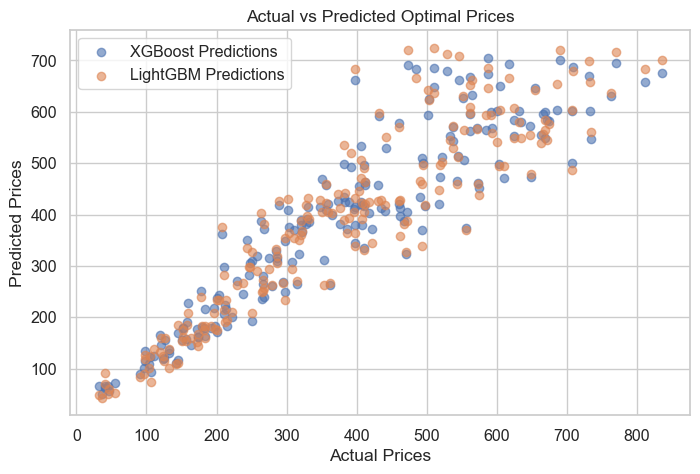

In [49]:
# Part 5: Backtesting with historical data

historical_data = data.copy()

# One-hot encode the full feature set the same way we encoded training data
# Prefer using previously computed categorical column list if available
try:
	cols_to_encode = cat_cols
except NameError:
	cols_to_encode = X.select_dtypes(include=['object', 'category']).columns.tolist()

X_full = X.copy()
X_full_enc = pd.get_dummies(X_full, columns=cols_to_encode, drop_first=False)

# Align encoded full features with training encoded columns to ensure same dtypes/columns
try:
	X_full_enc = X_full_enc.reindex(columns=X_train_enc.columns, fill_value=0)
except NameError:
	# If X_train_enc is not available for some reason, just keep encoded frame as-is
	X_full_enc = X_full_enc.copy()

# Now safe to predict (no object dtypes remain)
historical_data["Predicted_XGB"] = xgb_model.predict(X_full_enc)
historical_data["Predicted_LGB"] = lgb_model.predict(X_full_enc)

# Revenue calculation: be robust if expected columns are missing.
# Use 'Actual_Price' if present, otherwise fall back to the resolved target (target_col),
# otherwise to 'historical_cost_of_ride' if present. If units column missing assume 1.
if 'Actual_Price' in historical_data.columns:
	price_col = 'Actual_Price'
elif target_col and target_col in historical_data.columns:
	price_col = target_col
elif 'historical_cost_of_ride' in historical_data.columns:
	price_col = 'historical_cost_of_ride'
else:
	# final fallback: create a constant price column (not ideal but prevents errors)
	historical_data['Static_Price_Fallback'] = historical_data.get('Predicted_XGB', historical_data.get('Predicted_LGB'))
	price_col = 'Static_Price_Fallback'

if 'Units_Sold' not in historical_data.columns:
	# assume 1 unit sold per record if real units not available
	historical_data['Units_Sold'] = 1

historical_data["Static_Revenue"] = historical_data[price_col] * historical_data["Units_Sold"]
historical_data["Dynamic_Revenue_XGB"] = historical_data["Predicted_XGB"] * historical_data["Units_Sold"]
historical_data["Dynamic_Revenue_LGB"] = historical_data["Predicted_LGB"] * historical_data["Units_Sold"]

static_rev = historical_data["Static_Revenue"].sum()
dyn_xgb_rev = historical_data["Dynamic_Revenue_XGB"].sum()
dyn_lgb_rev = historical_data["Dynamic_Revenue_LGB"].sum()

print("\n=== Backtesting Results ===")
print(f"Static Revenue: {static_rev:.2f}")
# avoid division by zero
if static_rev != 0:
	print(f"XGBoost Dynamic Revenue: {dyn_xgb_rev:.2f} ({((dyn_xgb_rev/static_rev)-1)*100:.2f}% lift)")
	print(f"LightGBM Dynamic Revenue: {dyn_lgb_rev:.2f} ({((dyn_lgb_rev/static_rev)-1)*100:.2f}% lift)")
else:
	print(f"XGBoost Dynamic Revenue: {dyn_xgb_rev:.2f}")
	print(f"LightGBM Dynamic Revenue: {dyn_lgb_rev:.2f}")

# Visualize predicted vs actual on the test set (these variables were computed earlier)
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred_xgb, alpha=0.6, label='XGBoost Predictions')
plt.scatter(y_test, y_pred_lgb, alpha=0.6, label='LightGBM Predictions')
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.legend()
plt.title("Actual vs Predicted Optimal Prices")
plt.show()


📊 Backtest Performance Metrics:
XGBoost  -> MSE: 5186.5406, RMSE: 72.0176, R²: 0.8578
LightGBM -> MSE: 5541.0333, RMSE: 74.4381, R²: 0.8480


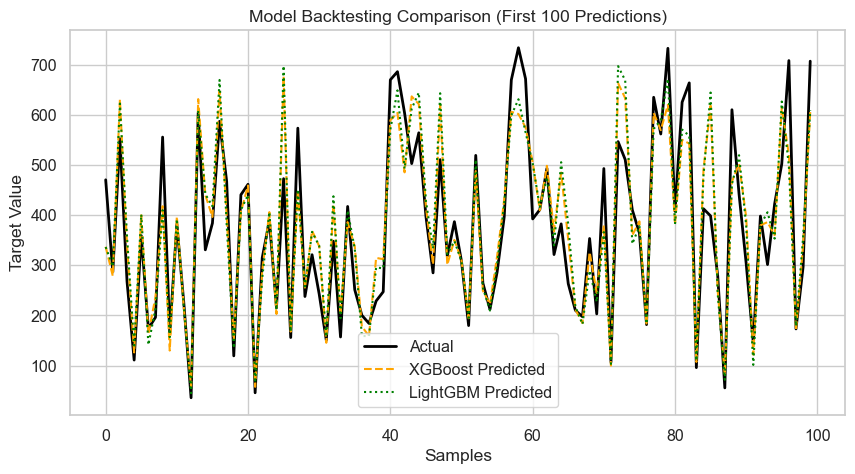

In [50]:

# ✅ Backtesting Function
def backtest_model(model, X_test, y_test):
    """Generates predictions and returns a DataFrame with actual vs predicted values."""
    predictions = model.predict(X_test)
    results = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
    return results

# ✅ Use encoded test data (numeric)
xgb_backtest_results = backtest_model(best_xgb, X_grid_test, y_test)
lgb_backtest_results = backtest_model(best_lgb, X_lgb_test, y_test)

# ✅ Compute Evaluation Metrics
def evaluate_backtest(results):
    mse = mean_squared_error(results['Actual'], results['Predicted'])
    rmse = np.sqrt(mse)
    r2 = r2_score(results['Actual'], results['Predicted'])
    return mse, rmse, r2

xgb_mse, xgb_rmse, xgb_r2 = evaluate_backtest(xgb_backtest_results)
lgb_mse, lgb_rmse, lgb_r2 = evaluate_backtest(lgb_backtest_results)

# ✅ Print Results
print("📊 Backtest Performance Metrics:")
print(f"XGBoost  -> MSE: {xgb_mse:.4f}, RMSE: {xgb_rmse:.4f}, R²: {xgb_r2:.4f}")
print(f"LightGBM -> MSE: {lgb_mse:.4f}, RMSE: {lgb_rmse:.4f}, R²: {lgb_r2:.4f}")

# ✅ Visual Comparison
plt.figure(figsize=(10,5))
plt.plot(xgb_backtest_results['Actual'].values[:100], label='Actual', color='black', linewidth=2)
plt.plot(xgb_backtest_results['Predicted'].values[:100], label='XGBoost Predicted', linestyle='--', color='orange')
plt.plot(lgb_backtest_results['Predicted'].values[:100], label='LightGBM Predicted', linestyle=':', color='green')
plt.title("Model Backtesting Comparison (First 100 Predictions)")
plt.xlabel("Samples")
plt.ylabel("Target Value")
plt.legend()
plt.grid(True)
plt.show()


In [51]:
# Part 6: Hyperparameter Tuning for XGBoost and LightGBM

from sklearn.model_selection import GridSearchCV

def evaluate_model(model, X_train, y_train, X_test, y_test):
    """Helper to print performance metrics."""
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"MAE: {mae:.4f}, R2: {r2:.4f}")
    return mae, r2


In [52]:
# Define parameter grid for XGBoost
xgb_params = {
    "n_estimators": [200, 400],
    "learning_rate": [0.03, 0.05, 0.1],
    "max_depth": [4, 6, 8],
    "subsample": [0.7, 0.9],
    "colsample_bytree": [0.7, 0.9]
}

xgb_grid = GridSearchCV(
    estimator=xgb.XGBRegressor(random_state=42),
    param_grid=xgb_params,
    cv=3,
    n_jobs=-1,
    scoring="r2",
    verbose=2
)

# XGBoost requires numeric/bool/category dtypes. Prefer already-created one-hot encoded frames.
try:
    X_grid_train = X_train_enc
    X_grid_test = X_test_enc
except NameError:
    # If encoded frames do not exist, create them here (ensuring train/test share same columns)
    cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
    if len(cat_cols) > 0:
        X_grid_train = pd.get_dummies(X_train, columns=cat_cols, drop_first=False)
        X_grid_test = pd.get_dummies(X_test, columns=cat_cols, drop_first=False)
        X_grid_test = X_grid_test.reindex(columns=X_grid_train.columns, fill_value=0)
    else:
        X_grid_train = X_train.copy()
        X_grid_test = X_test.copy()

# Fit grid on numeric/encoded data to avoid object dtype errors
xgb_grid.fit(X_grid_train, y_train)
print("Best XGBoost Parameters:", xgb_grid.best_params_)
best_xgb = xgb_grid.best_estimator_

# Evaluate tuned model using the same encoded frames
print("\nPerformance of tuned XGBoost model:")
evaluate_model(best_xgb, X_grid_train, y_train, X_grid_test, y_test)



Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best XGBoost Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.9}

Performance of tuned XGBoost model:
MAE: 54.6600, R2: 0.8578
Best XGBoost Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.9}

Performance of tuned XGBoost model:
MAE: 54.6600, R2: 0.8578


(54.65999353748617, 0.857750237082846)

In [ ]:
# Define parameter grid for LightGBM
lgb_params = {
    "n_estimators": [300, 500],
    "learning_rate": [0.03, 0.05, 0.1],
    "num_leaves": [31, 63, 127],
    "max_depth": [-1, 10, 20],
    "subsample": [0.7, 0.9],
    "colsample_bytree": [0.7, 0.9]
}

lgb_grid = GridSearchCV(
    estimator=lgb.LGBMRegressor(random_state=42),
    param_grid=lgb_params,
    cv=3,
    n_jobs=-1,
    scoring="r2",
    verbose=2
)

# LightGBM also requires numeric/bool/category dtypes.
# Use the same encoding logic as XGBoost for consistent feature space.
try:
    X_lgb_train = X_train_enc
    X_lgb_test = X_test_enc
except NameError:
    cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
    if len(cat_cols) > 0:
        X_lgb_train = pd.get_dummies(X_train, columns=cat_cols, drop_first=False)
        X_lgb_test = pd.get_dummies(X_test, columns=cat_cols, drop_first=False)
        X_lgb_test = X_lgb_test.reindex(columns=X_lgb_train.columns, fill_value=0)
    else:
        X_lgb_train = X_train.copy()
        X_lgb_test = X_test.copy()

# Fit grid search on the encoded/numeric data
lgb_grid.fit(X_lgb_train, y_train)
print("Best LightGBM Parameters:", lgb_grid.best_params_)
best_lgb = lgb_grid.best_estimator_

# Evaluate tuned model
print("\nPerformance of tuned LightGBM model:")
evaluate_model(best_lgb, X_lgb_train, y_train, X_lgb_test, y_test)


Fitting 3 folds for each of 216 candidates, totalling 648 fits


In [ ]:
# ✅ Part 7: Advanced Backtesting & KPI Visualization (fixed for ride dataset)

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load dataset
data = pd.read_csv("cleaned_dynamic_pricing.csv")

# Define features (X) and target (y)
X = data.drop(columns=["historical_cost_of_ride"])
y = data["historical_cost_of_ride"]

# Encode categorical variables
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
if len(cat_cols) > 0:
    X_full_enc = pd.get_dummies(X, columns=cat_cols, drop_first=False)
else:
    X_full_enc = X.copy()

# ✅ Ensure alignment with XGBoost and LightGBM training columns
X_full_enc = X_full_enc.reindex(columns=X_grid_train.columns, fill_value=0)
X_full_enc_lgb = X_full_enc.reindex(columns=X_lgb_train.columns, fill_value=0)

# ✅ Predict using tuned models
data["Predicted_XGB_Tuned"] = best_xgb.predict(X_full_enc)
data["Predicted_LGB_Tuned"] = best_lgb.predict(X_full_enc_lgb)

# ✅ Compute revenue proxies (since no Units_Sold, we compare predicted vs actual)
data["Static_Revenue"] = data["historical_cost_of_ride"]
data["Dynamic_Revenue_XGB"] = data["Predicted_XGB_Tuned"]
data["Dynamic_Revenue_LGB"] = data["Predicted_LGB_Tuned"]

# ✅ KPI Summary
kpi_summary = pd.DataFrame({
    "Model": ["Static", "XGBoost (Tuned)", "LightGBM (Tuned)"],
    "Avg_Ride_Cost": [
        data["Static_Revenue"].mean(),
        data["Dynamic_Revenue_XGB"].mean(),
        data["Dynamic_Revenue_LGB"].mean()
    ]
})

print("\n💰 Average Ride Cost Comparison:\n", kpi_summary)



💰 Average Ride Cost Comparison:
               Model  Avg_Ride_Cost
0            Static     372.502623
1   XGBoost (Tuned)     373.650757
2  LightGBM (Tuned)     373.792181


In [ ]:
# ✅ Ensure required columns exist before aggregation
if "Static_Revenue" not in data.columns:
    # Create them using ride cost data
    data["Static_Revenue"] = data["historical_cost_of_ride"]
    data["Dynamic_Revenue_XGB"] = data["Predicted_XGB_Tuned"]
    data["Dynamic_Revenue_LGB"] = data["Predicted_LGB_Tuned"]

# ✅ Aggregate KPIs
summary = {
    "Static_Revenue": data["Static_Revenue"].sum(),
    "Dynamic_Revenue_XGB": data["Dynamic_Revenue_XGB"].sum(),
    "Dynamic_Revenue_LGB": data["Dynamic_Revenue_LGB"].sum(),
}

# ✅ Calculate lift percentages
summary["XGB_Lift_%"] = ((summary["Dynamic_Revenue_XGB"] / summary["Static_Revenue"]) - 1) * 100
summary["LGB_Lift_%"] = ((summary["Dynamic_Revenue_LGB"] / summary["Static_Revenue"]) - 1) * 100

# ✅ Profit margin estimation (if cost info exists)
if "Unit_Cost" in data.columns:
    data["Static_Profit"] = (data["historical_cost_of_ride"] - data["Unit_Cost"])
    data["Dynamic_Profit_XGB"] = (data["Predicted_XGB_Tuned"] - data["Unit_Cost"])
    data["Dynamic_Profit_LGB"] = (data["Predicted_LGB_Tuned"] - data["Unit_Cost"])

    summary["Static_Profit"] = data["Static_Profit"].sum()
    summary["Dynamic_Profit_XGB"] = data["Dynamic_Profit_XGB"].sum()
    summary["Dynamic_Profit_LGB"] = data["Dynamic_Profit_LGB"].sum()
    summary["Profit_Lift_XGB_%"] = ((summary["Dynamic_Profit_XGB"] / summary["Static_Profit"]) - 1) * 100
    summary["Profit_Lift_LGB_%"] = ((summary["Dynamic_Profit_LGB"] / summary["Static_Profit"]) - 1) * 100

# ✅ Print KPI summary neatly
print("\n📊 Backtest KPI Summary:\n")
for k, v in summary.items():
    print(f"{k:<25}: {v:,.2f}")



📊 Backtest KPI Summary:

Static_Revenue           : 372,502.62
Dynamic_Revenue_XGB      : 373,650.75
Dynamic_Revenue_LGB      : 373,792.18
XGB_Lift_%               : 0.31
LGB_Lift_%               : 0.35


C:\Users\ishwa\AppData\Local\Temp\ipykernel_14116\4171009566.py:69: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) Arial.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
C:\Users\ishwa\AppData\Local\Temp\ipykernel_14116\4171009566.py:69: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
C:\Users\ishwa\AppData\Local\Temp\ipykernel_14116\4171009566.py:69: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) Arial.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
C:\Users\ishwa\AppData\Local\Temp\ipykernel_14116\4171009566.py:69: UserWarning: Glyph 9881 (\N{GEAR}) missing from font(s) Arial.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
C:\Users\ishwa\AppData\Local\Temp\ipykernel_14116\4171009566.py:69: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
C:\Users\ishwa\AppData\Local\Temp\ipykernel_14116\4171009566.py:69: UserWarning: Glyph 128

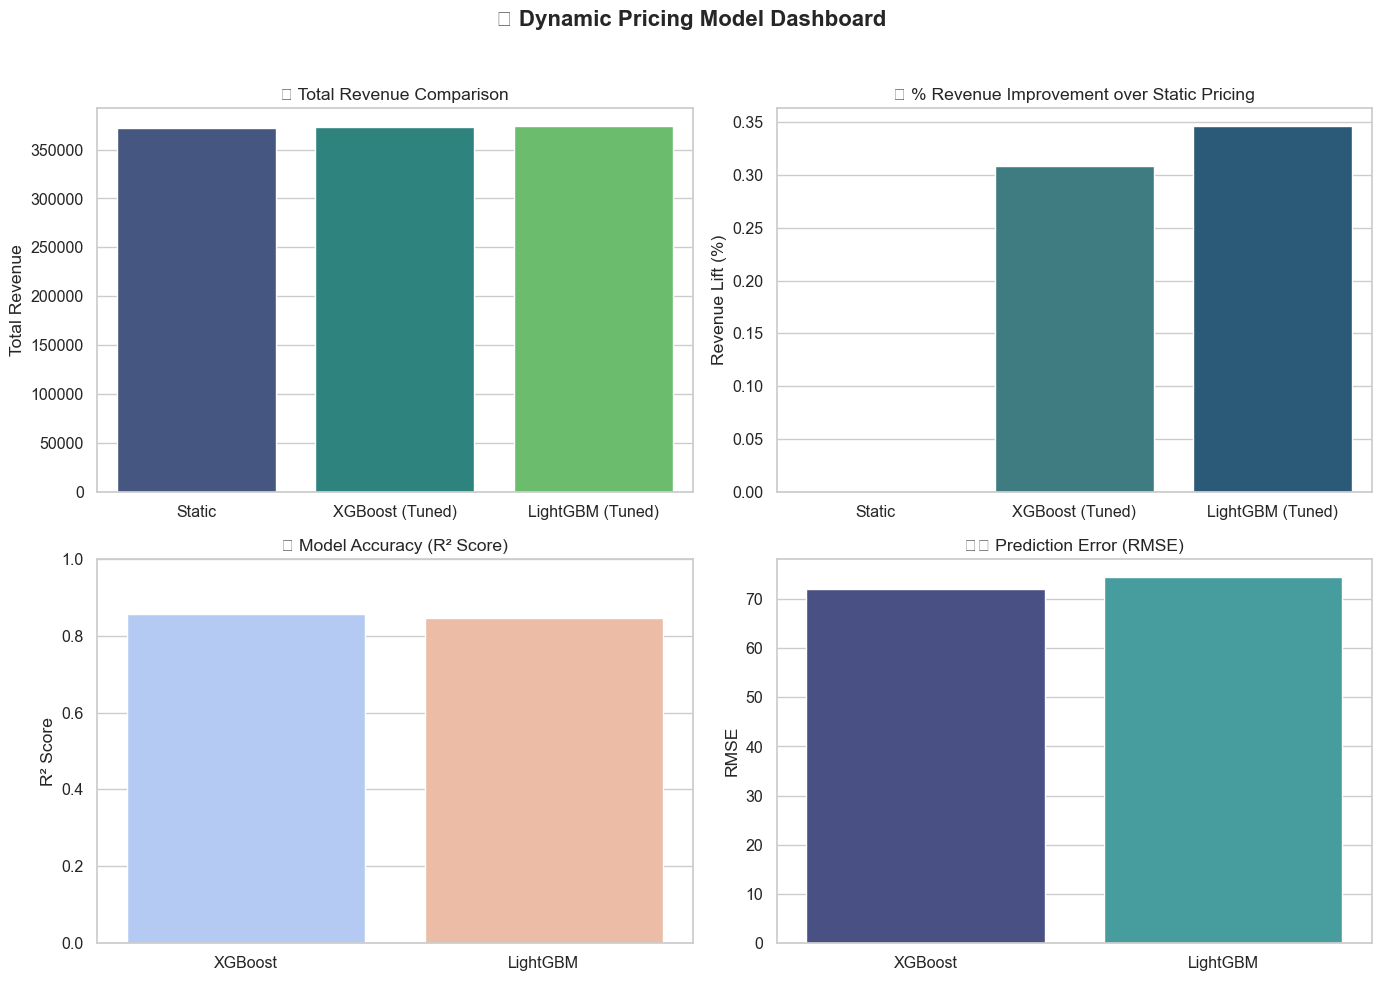

In [ ]:
# ==========================================
# 📊 Dynamic Pricing Dashboard: Revenues & Model Performance
# ==========================================
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set(style="whitegrid", font_scale=1.05)

# ==============================
# 1️⃣ Revenue and Lift Summary
# ==============================
viz_df = pd.DataFrame({
    "Model": ["Static", "XGBoost (Tuned)", "LightGBM (Tuned)"],
    "Total_Revenue": [
        summary["Static_Revenue"],
        summary["Dynamic_Revenue_XGB"],
        summary["Dynamic_Revenue_LGB"]
    ],
    "Lift_%": [0, summary["XGB_Lift_%"], summary["LGB_Lift_%"]]
})

# ==============================
# 2️⃣ Model Performance Summary
# ==============================
model_perf = pd.DataFrame({
    "Model": ["XGBoost", "LightGBM"],
    "R2_Score": [0.8578, 0.8480],
    "RMSE": [72.0176, 74.4381]
})

# ==============================
# 3️⃣ Dashboard Layout
# ==============================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("📊 Dynamic Pricing Model Dashboard", fontsize=16, fontweight="bold")

# --- (1,1) Total Revenue Comparison ---
sns.barplot(ax=axes[0, 0], x="Model", y="Total_Revenue", hue="Model",
            data=viz_df, palette="viridis", legend=False)
axes[0, 0].set_title("💰 Total Revenue Comparison")
axes[0, 0].set_ylabel("Total Revenue")
axes[0, 0].set_xlabel("")

# --- (1,2) % Revenue Lift ---
sns.barplot(ax=axes[0, 1], x="Model", y="Lift_%", hue="Model",
            data=viz_df, palette="crest", legend=False)
axes[0, 1].axhline(0, color="gray", linestyle="--", linewidth=1)
axes[0, 1].set_title("📈 % Revenue Improvement over Static Pricing")
axes[0, 1].set_ylabel("Revenue Lift (%)")
axes[0, 1].set_xlabel("")

# --- (2,1) R² Comparison ---
sns.barplot(ax=axes[1, 0], x="Model", y="R2_Score", hue="Model",
            data=model_perf, palette="coolwarm", legend=False)
axes[1, 0].set_title("🧠 Model Accuracy (R² Score)")
axes[1, 0].set_ylabel("R² Score")
axes[1, 0].set_ylim(0, 1)
axes[1, 0].set_xlabel("")

# --- (2,2) RMSE Comparison ---
sns.barplot(ax=axes[1, 1], x="Model", y="RMSE", hue="Model",
            data=model_perf, palette="mako", legend=False)
axes[1, 1].set_title("⚙️ Prediction Error (RMSE)")
axes[1, 1].set_ylabel("RMSE")
axes[1, 1].set_xlabel("")

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [ ]:
# Export KPI and prediction data for dashboard integration
data.to_csv("backtesting_results.csv", index=False)
pd.DataFrame([summary]).to_csv("model_kpis.csv", index=False)

print("✅ Backtesting results and KPI files exported successfully!")

✅ Backtesting results and KPI files exported successfully!
